## Making a car classifier using Pytorch

Dataset (196 classes):

Train folder: 8144 images, avg: 41.5 images per class.

Test folder: 8041 images, avg: 41.0 images per class.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce GTX 1060 6GB


## Load the data and transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 400x400 images with random horizontal flip, random rotation and normalization

In [19]:
dataset_dir = "input/stanford-car-dataset-by-classes-folder/car_data/car_data/"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)


## Model training function

Here we train our model, after each epoch, we test the model on the test data to see how it's going

In [20]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

    

### Evaluate on training data
This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

In [21]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [23]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 196 s, loss: 4.0495, acc: 14.2402
Accuracy of the network on the test images: 31 %
Epoch 2, duration: 184 s, loss: 1.7410, acc: 54.7794
Accuracy of the network on the test images: 57 %
Epoch 3, duration: 181 s, loss: 0.9125, acc: 74.5711
Accuracy of the network on the test images: 72 %
Epoch 4, duration: 177 s, loss: 0.5577, acc: 84.5343
Accuracy of the network on the test images: 75 %
Epoch 5, duration: 175 s, loss: 0.3521, acc: 90.3922
Accuracy of the network on the test images: 79 %
Epoch 6, duration: 175 s, loss: 0.2592, acc: 92.7819
Accuracy of the network on the test images: 82 %
Epoch 7, duration: 175 s, loss: 0.1665, acc: 95.6127
Accuracy of the network on the test images: 82 %
Epoch 8, duration: 175 s, loss: 0.0823, acc: 98.3088
Accuracy of the network on the test images: 89 %
Epoch 9, duration: 177 s, loss: 0.0550, acc: 98.8235
Accuracy of the network on the test images: 90 %
Epoch 10, duration: 187 s, loss: 0.0479, acc: 99.0319
Accuracy of the network on t

### As we can see the model reached 90% training accuracy by epoch 10.


Text(0.5, 1.0, 'Test acc')

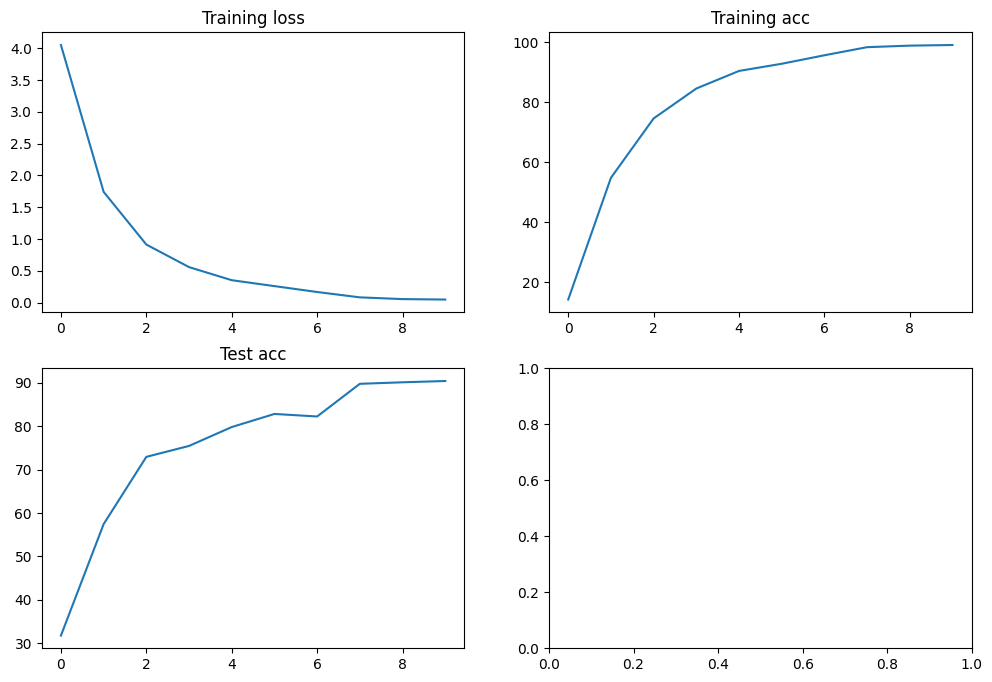

In [24]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

### Evaluate the model on single images (e.g for production)

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


In [25]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [26]:
# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

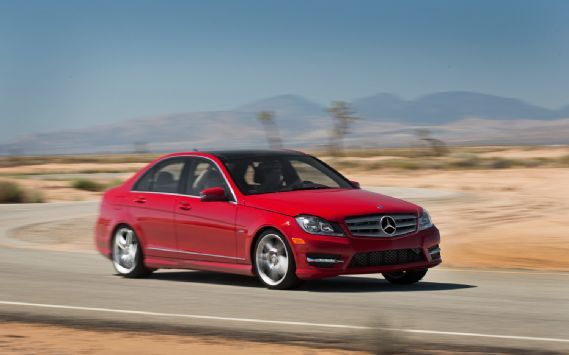

Mercedes-Benz C-Class Sedan 2012 confidence:  13.539864540100098


(None,)

In [27]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item()),

In [28]:
example_input = torch.rand(1, 3, 400, 400)
traced_script_module = torch.jit.trace(model_ft, example_input.cuda())
traced_script_module.save("traced_car_classifier.pt")


In [29]:
output = traced_script_module(image.cuda())
conf, predicted = torch.max(output.data, 1)
print(classes[predicted.item()], "confidence: ", conf.item())

Mercedes-Benz C-Class Sedan 2012 confidence:  13.539864540100098


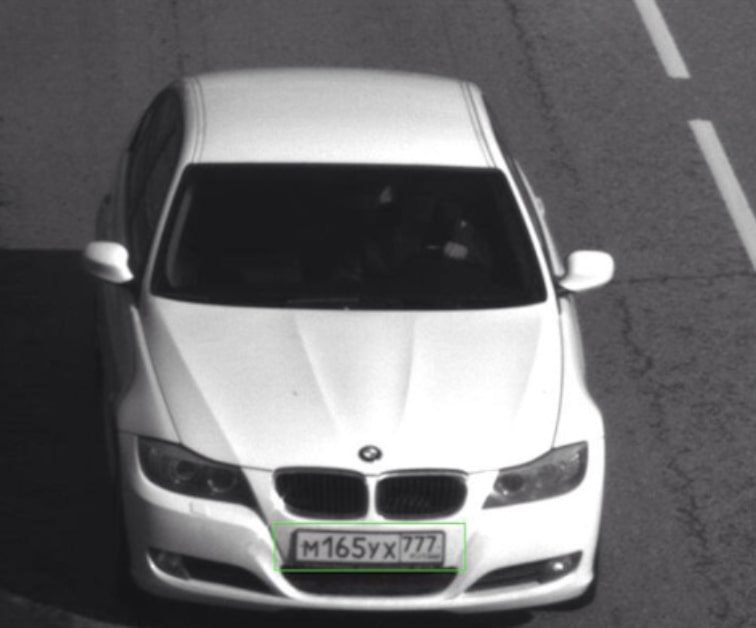

BMW M3 Coupe 2012 confidence:  11.440743446350098


In [33]:
loader = transforms.Compose([transforms.Resize((400, 400)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open("W:/Programming/torch_serve/examples/bmwM3.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
display(Image.open("W:/Programming/torch_serve/examples/bmwM3.jpg"))

output = traced_script_module(image.cuda())
conf, predicted = torch.max(output.data, 1)
print(classes[predicted.item()], "confidence: ", conf.item())

In [ ]:
loader = transforms.Compose([#transforms.Resize((400, 400)),
                              transforms.ToTensor(),
                             transforms.RandomHorizontalFlip(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                #transforms.Grayscale()
                             ])

display(Image.open("W:/Programming/torch_serve/examples/bmwM5_2010.jpg"))
image = Image.open("W:/Programming/torch_serve/examples/bmwM5_2010.jpg")
image = loader(image)
display(transforms.ToPILImage()(image))
# display(image)